In [1]:
## Import Packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import backend as K
from keras import initializers
from keras.regularizers import l1, l2, l1_l2
from keras.models import Sequential, Model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, Concatenate, Reshape, Multiply, Flatten, Dropout
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
from time import time
import sys, os
import argparse
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('colorblind')
sns.set_context('talk')

Using TensorFlow backend.


## Read in Champaign user-item interaction csv file to generate dataset:

In [2]:
champaign_user_item_df = pd.read_csv('../yelp_dataset/champaign_user_item.csv', index_col = 0)
champaign_user_item_df.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_business_avg,review_count,...,categories,hours,review_id,user_id,stars,useful,funny,cool,text,date
0,4hWDMVtfnpyY72_5QMbthA,Old Time Meat & Deli Shoppe,2018 S Neil St,urbana-champaign,IL,61820.0,40.091901,-88.245362,5.0,46,...,"Meat Shops, Food, Restaurants, Specialty Food,...","{'Monday': '10:0-18:0', 'Tuesday': '10:0-18:0'...",WruGbPJAuXAl5GP28fH1cA,5rM50rIojxWNQRv0Vmuulg,5.0,0,0,0,This is a wonderful butchershop. Deli selectio...,2011-08-25 01:04:12
1,4hWDMVtfnpyY72_5QMbthA,Old Time Meat & Deli Shoppe,2018 S Neil St,urbana-champaign,IL,61820.0,40.091901,-88.245362,5.0,46,...,"Meat Shops, Food, Restaurants, Specialty Food,...","{'Monday': '10:0-18:0', 'Tuesday': '10:0-18:0'...",NozR-GCiMHWyhqRbW4TDuA,9ZuE5YJQvNA4PvldrTgmXA,5.0,1,1,1,I'm almost reluctant to give it 5 stars only s...,2016-04-12 05:07:23
2,4hWDMVtfnpyY72_5QMbthA,Old Time Meat & Deli Shoppe,2018 S Neil St,urbana-champaign,IL,61820.0,40.091901,-88.245362,5.0,46,...,"Meat Shops, Food, Restaurants, Specialty Food,...","{'Monday': '10:0-18:0', 'Tuesday': '10:0-18:0'...",wLWG8YkhTfu3zjAYGNSzfA,w-NiZLoY-TetMRY8LOqMKw,5.0,1,0,2,This is definitely the place to go for excelle...,2016-07-04 01:09:58


In [3]:
unique_business_id = champaign_user_item_df.business_id.unique()
mapping_business_id = {}
ctr = 0
for business_id in unique_business_id:
    mapping_business_id[business_id] = ctr
    ctr += 1
    
champaign_user_item_df['business_id_refined'] = champaign_user_item_df.business_id.map(mapping_business_id)

In [4]:
unique_user_id = champaign_user_item_df.user_id.unique()
mapping_user_id = {}
ctr = 0
for user_id in unique_user_id:
    mapping_user_id[user_id] = ctr
    ctr += 1
    
champaign_user_item_df['user_id_refined'] = champaign_user_item_df.user_id.map(mapping_user_id)

In [5]:
champaign_user_item_df[['user_id_refined', 'business_id_refined']].head(5)

,user_id_refined,business_id_refined
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [6]:
sum(champaign_user_item_df.groupby('user_id_refined')['name'].count() >= 10)

502

There are only 502 users who have reviewed 10 or more restaurants in champaign, hence need to expand the dataset a bit

## Read in toronto user-item interaction csv file to generate dataset:

In [7]:
toronto_user_item_final_df = pd.read_csv('../yelp_dataset/toronto_user_item_final_df.csv', index_col = 0)
dataset_to_use = toronto_user_item_final_df.copy()

In [8]:
dataset_to_use.columns

Index(['business_id', 'name_x', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars_business_avg', 'review_count_x',
       'is_open', 'attributes', 'categories', 'hours', 'review_id', 'user_id',
       'stars', 'useful_x', 'funny_x', 'cool_x', 'text', 'date', 'name_y',
       'review_count_y', 'yelping_since', 'useful_y', 'funny_y', 'cool_y',
       'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')

In [9]:
num_users = dataset_to_use.user_id.nunique()
num_items = dataset_to_use.business_id.nunique()

In [10]:
len(dataset_to_use)

227663

In [11]:
print('There are %d unique users and %d unique items in the dataset after filtering such that each user has \
reviewed at least 10 restaurants.'%(num_users, num_items))

There are 7905 unique users and 8546 unique items in the dataset after filtering such that each user has reviewed at least 10 restaurants.


In [12]:
dataset_to_use.head(3)

,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_business_avg,review_count_x,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,g6AFW-zY0wDvBl9U82g4zg,Baretto Caffe,1262 Don Mills Road,toronto,ON,M3B 2W7,43.744703,-79.346468,5.0,317,...,1,0,0,0,0,1,0,0,0,0
1,gAxeeJKwJtxp3uH9zUQ2aQ,A-Game Cafe,797 Dundas Street W,toronto,ON,M6J 1V2,43.651719,-79.407911,4.5,91,...,1,0,0,0,0,1,0,0,0,0
2,cWPTOM_o5toaXpq0gNxD7Q,Vanta Coffee Club & Eatery,2101 Brimley Road,toronto,ON,M1S 2B4,43.788839,-79.268636,4.0,204,...,1,0,0,0,0,1,0,0,0,0


In [13]:
print('There are %d unique users and %d unique items in the dataset after filtering such that each user has \
reviewed at least 10 restaurants.'%(dataset_to_use.user_id.nunique(), dataset_to_use.business_id.nunique()))

There are 7905 unique users and 8546 unique items in the dataset after filtering such that each user has reviewed at least 10 restaurants.


### Create simpler IDs for users and items

In [14]:
unique_business_id = dataset_to_use.business_id.unique()
mapping_business_id = {}
ctr = 0
for business_id in unique_business_id:
    mapping_business_id[business_id] = ctr
    ctr += 1
    
dataset_to_use['business_id_refined'] = dataset_to_use.business_id.map(mapping_business_id)

unique_user_id = dataset_to_use.user_id.unique()
mapping_user_id = {}
ctr = 0
for user_id in unique_user_id:
    mapping_user_id[user_id] = ctr
    ctr += 1
    
dataset_to_use['user_id_refined'] = dataset_to_use.user_id.map(mapping_user_id)


display(dataset_to_use[['user_id_refined', 'business_id_refined']].head(5))

dataset_to_use.sort_values(by = ['user_id_refined', 'date'], inplace = True)

dataset_to_use.head(3)

,user_id_refined,business_id_refined
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4


,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_business_avg,review_count_x,...,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,business_id_refined,user_id_refined
12,e49eXgKVuR-lsL0-D4vzDw,Momiji,2111 Sheppard Avenue E,toronto,ON,M2J 1W6,43.775377,-79.333972,3.0,22,...,0,0,0,1,0,0,0,0,12,0
10,ik9VvawL-BeAqlxTI1leew,Gonoe Sushi,1310 Don Mills Road,toronto,ON,M3B 2W6,43.745920,-79.346301,3.5,119,...,0,0,0,1,0,0,0,0,10,0
3,Nz44ccUso3nq5S2OlQHNlA,Mexico Lindo,"2600 Birchmount Road, Suite 2586",toronto,ON,M1T 2M5,43.789719,-79.302981,4.0,163,...,0,0,0,1,0,0,0,0,3,0


## Test Data:

In [15]:
def last_values(df):
    return df.iloc[-4:]

# Save the 4 most recent visit to a restaurant as the test data
test_data = dataset_to_use.groupby('user_id_refined').apply(last_values)

In [16]:
test_data.head(3)

business_id                      name_x  \
user_id_refined                                                         
0               2  cWPTOM_o5toaXpq0gNxD7Q  Vanta Coffee Club & Eatery   
                8  Dib3cIHWyDVKDZTMm580iQ                  Rolltation   
                7  T4iG8nhlu3uVnRzRn6660w              The Dock Ellis   

                                address     city state postal_code   latitude  \
user_id_refined                                                                 
0               2     2101 Brimley Road  toronto    ON     M1S 2B4  43.788839   
                8      758 Yonge Street  toronto    ON     M4Y 2B6  43.669377   
                7  1280 Dundas Street W  toronto    ON     M6J 1X7  43.649470   

                   longitude  stars_business_avg  review_count_x  ...  \
user_id_refined                                                   ...   
0               2 -79.268636                 4.0             204  ...   
                8 -79.386539                 4.0              36  ...   
                7 -79.425329                 4.0              51  ...   

                   compliment_cute compliment_list compliment_note  \
user_id_refined                                                      
0               2                0               0               0   
                8                0               0               0   
                7                0               0               0   

                  compliment_plain compliment_cool compliment_funny  \
user_id_refined                                                       
0               2                1               0                0   
                8                1               0                0   
                7                1               0                0   

                   compliment_writer  compliment_photos  business_id_refined  \
user_id_refined                                                                
0               2                  0                  0                    2   
                8                  0                  0                    8   
                7                  0                  0                    7   

                   user_id_refined  
user_id_refined                     
0               2                0  
                8                0  
                7                0  

[3 rows x 45 columns]

In [17]:
dataset_to_use.query('user_id_refined == 0')['business_id_refined'].iloc[-1],\
dataset_to_use.query('user_id_refined == 1')['business_id_refined'].iloc[-1],\
dataset_to_use.query('user_id_refined == 2')['business_id_refined'].iloc[-1]

(0, 19, 64)

In [18]:
test_data = test_data.droplevel(0)
test_data.head(3)

,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_business_avg,review_count_x,...,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,business_id_refined,user_id_refined
2,cWPTOM_o5toaXpq0gNxD7Q,Vanta Coffee Club & Eatery,2101 Brimley Road,toronto,ON,M1S 2B4,43.788839,-79.268636,4.0,204,...,0,0,0,1,0,0,0,0,2,0
8,Dib3cIHWyDVKDZTMm580iQ,Rolltation,758 Yonge Street,toronto,ON,M4Y 2B6,43.669377,-79.386539,4.0,36,...,0,0,0,1,0,0,0,0,8,0
7,T4iG8nhlu3uVnRzRn6660w,The Dock Ellis,1280 Dundas Street W,toronto,ON,M6J 1X7,43.649470,-79.425329,4.0,51,...,0,0,0,1,0,0,0,0,7,0


In [19]:
X_test = np.array(test_data[['user_id_refined', 'business_id_refined']].values.tolist())
X_test

array([[   0,    2],
       [   0,    8],
       [   0,    7],
       ...,
       [7904, 8480],
       [7904, 6951],
       [7904, 2265]])

In [20]:
y_test = np.array(test_data['stars']) / 5.0
y_test

array([1. , 1. , 1. , ..., 0.4, 0.2, 0.2])

In [21]:
len(y_test) == len(X_test)

True

## Train Data:

In [22]:
# Save all visits to a restaurant except the last 4 as the train data
def all_values_except_last(df):
    return df.iloc[:-4]

In [23]:
train_data = dataset_to_use.groupby('user_id_refined').apply(all_values_except_last)

In [24]:
train_data = train_data.droplevel(0)
train_data.head(3)

,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_business_avg,review_count_x,...,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,business_id_refined,user_id_refined
12,e49eXgKVuR-lsL0-D4vzDw,Momiji,2111 Sheppard Avenue E,toronto,ON,M2J 1W6,43.775377,-79.333972,3.0,22,...,0,0,0,1,0,0,0,0,12,0
10,ik9VvawL-BeAqlxTI1leew,Gonoe Sushi,1310 Don Mills Road,toronto,ON,M3B 2W6,43.745920,-79.346301,3.5,119,...,0,0,0,1,0,0,0,0,10,0
3,Nz44ccUso3nq5S2OlQHNlA,Mexico Lindo,"2600 Birchmount Road, Suite 2586",toronto,ON,M1T 2M5,43.789719,-79.302981,4.0,163,...,0,0,0,1,0,0,0,0,3,0


In [25]:
len(train_data), len(test_data), len(train_data) + len(test_data) == len(dataset_to_use)

(196043, 31620, True)

In [26]:
X_train = np.array(train_data[['user_id_refined', 'business_id_refined']].values.tolist())
X_train

array([[   0,   12],
       [   0,   10],
       [   0,    3],
       ...,
       [7904, 3567],
       [7904, 6964],
       [7904, 2043]])

In [27]:
len(X_train)

196043

In [28]:
y_train = np.array(train_data['stars']) / 5.0
y_train

array([0.6, 0.6, 1. , ..., 0.8, 0.2, 0.6])

In [29]:
len(y_train) == len(X_train)

True

In [30]:
print('Train:Test Split is {0}:{1}'.format(len(test_data)/len(dataset_to_use), len(train_data)/len(dataset_to_use)))

Train:Test Split is 0.13888949895239894:0.861110501047601


In [31]:
def get_train_instances(X, y):
    X = np.array(X)
    users, items = X[:, 0], X[:, 1]
    ratings = y
    
    return users, items, ratings

In [32]:
def evaluate_model(model, X, y):
    """
    Return: score of each test rating.
    """
    users, items, ratings = get_train_instances(X, y)
        
    predictions = model.predict([users, items], batch_size = 1000, verbose = 0)

    y_actual = np.array(y) * 5
    y_pred = np.array(predictions) * 5
    assert len(y_pred) == len(y_actual)
    mse = mean_squared_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)
    
    return (mse, r2)

# (1) GMF Implementation:

In [33]:
def get_gmf_model(num_users, num_items, latent_dims, regs = [0,0]):
    # Input variables
    user_input = Input(shape=(1,), dtype='float32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='float32', name = 'item_input')

    MF_Embedding_User_ID = Embedding(input_dim = num_users, output_dim = latent_dims, name = 'user_embedding',
                                     embeddings_initializer='random_normal', embeddings_regularizer = l2(regs[0]),
                                     input_length = 1)
    MF_Embedding_Item_ID = Embedding(input_dim = num_items, output_dim = latent_dims, name = 'item_embedding',
                                     embeddings_initializer='random_normal', embeddings_regularizer = l2(regs[1]),
                                     input_length = 1)
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User_ID(user_input))
    item_latent = Flatten()(MF_Embedding_Item_ID(item_input))
    
    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_latent, item_latent])
    
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(predict_vector)
    
    model = Model(inputs = [user_input, item_input], outputs = prediction)

    return model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Initial: Test RMSE = 1.7040, Test R2 = -0.8886
Epoch 1 [1.0 s]: Test RMSE = 1.3381, Test R2 = -0.1646, Train RMSE = 1.3352 [0.0 s]
Epoch 2 [0.7 s]: Test RMSE = 1.2668, Test R2 = -0.0438, Train RMSE = 1.1480 [0.0 s]
Epoch 3 [0.7 s]: Test RMSE = 1.2496, Test R2 = -0.0156, Train RMSE = 1.1127 [0.0 s]
Epoch 4 [0.8 s]: Test RMSE = 1.2443, Test R2 = -0.0071, Train RMSE = 1.1048 [0.0 s]
Epoch 5 [0.8 s]: Test RMSE = 1.2424, Test R2 = -0.0040, Train RMSE = 1.1028 [0.0 s]
Epoch 6 [0.9 s]: Test RMSE = 1.2416, Test R2 = -0.0027, Train RMSE = 1.1022 [0.0 s]
Epoch 7 [0.7 s]: Test RMSE = 1.2413, Test R2 = -0.0022, Train RMSE = 1.1021 [0.0 s]
Epoch 8 [0.7 s]: Test RMSE = 1.2411, Test R2 = -0.0020, Train RMSE = 1.1020 [0.0 s]
Epoch 9 [0.8 s]: Test RMSE = 1.2410, Test R2 = -0.0018, Train RMSE = 1.1020 [0.0 s]
Epoch 10 [0.8 s]: Test RMSE = 1.2410, Test R2 = -0.0017, Train RMSE = 1.1020 [0.0 s]
Epoch 11 [0.8 s]: Test RMSE = 

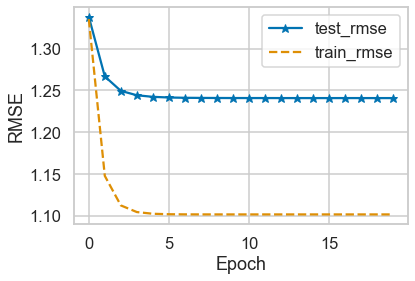

In [34]:
# Build model
regs = [0, 0]
learner = 'sgd'
learning_rate = 0.01
num_epochs = 20
batch_size = 256
out = 1
latent_dims = 21

model = get_gmf_model(num_users, num_items, latent_dims, regs)

if learner.lower() == "adagrad": 
    model.compile(optimizer=Adagrad(lr=learning_rate), loss='mse')
elif learner.lower() == "rmsprop":
    model.compile(optimizer=RMSprop(lr=learning_rate), loss='mse')
elif learner.lower() == "adam":
    model.compile(optimizer=Adam(lr=learning_rate), loss='mse')
else:
    model.compile(optimizer=SGD(lr=learning_rate), loss='mse')

# Initial performance
(mse, r2) = evaluate_model(model, X_test, y_test)
print('Initial: Test RMSE = %.4f, Test R2 = %.4f' % (np.sqrt(mse), r2))

# Training and testing model
current_folder = os.getcwd()
model_out_file_gmf = current_folder + '\\Pretrain\\toronto_GMF.h5'

train_loss = []
test_rmse, test_r2 = [], []
best_mse = float('inf')

# Generate training instances
user_input, item_input, ratings = get_train_instances(X_train, y_train)

for epoch in range(num_epochs):
    t1 = time()
        
    # Training
    history = model.fit([user_input, item_input], # input
                         np.array(ratings), # labels
                         batch_size = batch_size, epochs = 1, verbose = 0)

    train_loss.append(np.sqrt(history.history['loss'][0]) * 5) # multiply loss by 5 because the ratings are normalized by 5
    
    t2 = time()

    # Evaluation
    
    (mse, r2) = evaluate_model(model, X_test, y_test)

    test_rmse.append(np.sqrt(mse))
    test_r2.append(r2)

    print('Epoch %d [%.1f s]: Test RMSE = %.4f, Test R2 = %.4f, Train RMSE = %.4f [%.1f s]' 
          % (epoch + 1,  t2 - t1, test_rmse[-1], test_r2[-1], train_loss[-1], time() - t2))

    if mse < best_mse:
        best_mse, best_r2, best_iter = mse, r2, epoch + 1
        if out > 0:
            model.save_weights(model_out_file_gmf, overwrite = True)

print("End. Best Epoch %d: Test RMSE = %.4f, Test R2 score = %.4f. " %(best_iter, np.sqrt(best_mse), best_r2))
if out > 0:
    print("The best GMF model is saved") 
    
plt.plot(test_rmse, '*-', label = 'test_rmse')
plt.plot(train_loss, '--', label = 'train_rmse')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()

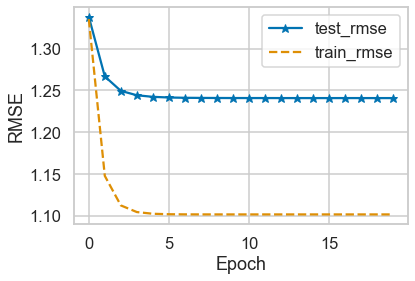

In [35]:
plt.plot(test_rmse, '*-', label = 'test_rmse')
plt.plot(train_loss, '--', label = 'train_rmse')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()

# (2) MLP Implementation:

In [36]:
def get_mlp_model(num_users, num_items, latent_dims, layers = [20,10], reg_layers=[0,0]):
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) #Number of layers in the MLP
    
    # Input variables
    user_input = Input(shape=(1,), dtype='float32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='float32', name = 'item_input')
    
    MLP_Embedding_User_ID = Embedding(input_dim = num_users, output_dim = latent_dims, name = 'user_embedding',
                                   embeddings_initializer='random_normal', embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)
    MLP_Embedding_Item_ID = Embedding(input_dim = num_items, output_dim = latent_dims, name = 'item_embedding',
                                   embeddings_initializer='random_normal', embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MLP_Embedding_User_ID(user_input))
    item_latent = Flatten()(MLP_Embedding_Item_ID(item_input))
    
    # The 0-th layer is the concatenation of embedding layers
    vector = Concatenate()([user_latent, item_latent])
    
    # MLP layers
    for idx in range(1, num_layer):
        layer = Dense(layers[idx], kernel_regularizer = l2(reg_layers[idx]), activation='relu', name = 'layer%d' %idx)
        vector = layer(vector)
        
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(vector)
    model = Model(inputs = [user_input, item_input], outputs = prediction)
    
    return model

In [ ]:
# Build model
layers = [32, 16, 8, 4]
reg_layers = [0, 0, 0, 0]
learner = 'adam'
learning_rate = 0.001

model = get_mlp_model(num_users, num_items, latent_dims, layers, reg_layers)

if learner.lower() == "adagrad":
    model.compile(optimizer=Adagrad(lr=learning_rate), loss='mse')
elif learner.lower() == "rmsprop":
    model.compile(optimizer=RMSprop(lr=learning_rate), loss='mse')
elif learner.lower() == "adam":
    model.compile(optimizer=Adam(lr=learning_rate), loss='mse')
else:
    model.compile(optimizer=SGD(lr=learning_rate), loss='mse')

# Initial performance
(mse, r2) = evaluate_model(model, X_test, y_test)
print('Initial: Test RMSE = %.4f, Test R2 = %.4f' % (np.sqrt(mse), r2))

# Training and testing model
current_folder = os.getcwd()
model_out_file_mlp = current_folder + '\\Pretrain\\toronto_MLP.h5'

train_loss = []
test_rmse, test_r2 = [], []
best_mse = float('inf')

# Generate training instances
user_input, item_input, ratings = get_train_instances(X_train, y_train)

for epoch in range(num_epochs):
    t1 = time()
    
    # Training
    history = model.fit([user_input, item_input], # input
                         np.array(ratings), # labels
                         batch_size = batch_size, epochs = 1, verbose = 0)

    train_loss.append(np.sqrt(history.history['loss'][0]) * 5) # multiply loss by 5 because the ratings are normalized by 5
    
    t2 = time()

    # Evaluation
    (mse, r2) = evaluate_model(model, X_test, y_test)

    test_rmse.append(np.sqrt(mse))
    test_r2.append(r2)

    print('Epoch %d [%.1f s]: Test RMSE = %.4f, Test R2 = %.4f, Train RMSE = %.4f [%.1f s]' 
          % (epoch + 1,  t2 - t1, test_rmse[-1], test_r2[-1], train_loss[-1], time() - t2))

    if mse < best_mse:
        best_mse, best_r2, best_iter = mse, r2, epoch + 1
        if out > 0:
            model.save_weights(model_out_file_mlp, overwrite = True)

print("End. Best Epoch %d: Test RMSE = %.4f, Test R2 score = %.4f. " %(best_iter, np.sqrt(best_mse), best_r2))
if out > 0:
    print("The best MLP model is saved")
    
    
plt.plot(test_rmse, '*-', label = 'test_rmse')
plt.plot(train_loss, '--', label = 'train_rmse')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('MLP')
plt.show()

Initial: Test RMSE = 1.7115, Test R2 = -0.9053
Epoch 1 [2.4 s]: Test RMSE = 1.1339, Test R2 = 0.1636, Train RMSE = 1.0735 [0.0 s]
Epoch 2 [1.6 s]: Test RMSE = 1.1199, Test R2 = 0.1842, Train RMSE = 0.9603 [0.0 s]
Epoch 3 [1.6 s]: Test RMSE = 1.1243, Test R2 = 0.1778, Train RMSE = 0.9343 [0.0 s]
Epoch 4 [1.6 s]: Test RMSE = 1.1331, Test R2 = 0.1648, Train RMSE = 0.9117 [0.0 s]
Epoch 5 [1.6 s]: Test RMSE = 1.1499, Test R2 = 0.1399, Train RMSE = 0.8858 [0.0 s]
Epoch 6 [1.6 s]: Test RMSE = 1.1646, Test R2 = 0.1177, Train RMSE = 0.8563 [0.0 s]
Epoch 7 [1.7 s]: Test RMSE = 1.1758, Test R2 = 0.1007, Train RMSE = 0.8248 [0.0 s]
Epoch 8 [1.6 s]: Test RMSE = 1.1967, Test R2 = 0.0685, Train RMSE = 0.7933 [0.0 s]
Epoch 9 [1.7 s]: Test RMSE = 1.2168, Test R2 = 0.0370, Train RMSE = 0.7635 [0.0 s]
Epoch 10 [1.7 s]: Test RMSE = 1.2380, Test R2 = 0.0031, Train RMSE = 0.7362 [0.0 s]
Epoch 11 [1.8 s]: Test RMSE = 1.2474, Test R2 = -0.0121, Train RMSE = 0.7106 [0.0 s]
Epoch 12 [1.7 s]: Test RMSE = 1.2631,

# (3) NeuMF Implementation:

In [ ]:
def get_ncf_model(num_users, num_items, latent_dims, layers=[10], reg_layers=[0], reg_mf=0):
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) # Number of layers in the MLP
    
    # Input variables
    user_input = Input(shape=(1,), dtype='float32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='float32', name = 'item_input')
    
    # Embedding layer GMF
    MF_Embedding_User_ID = Embedding(input_dim = num_users, output_dim = latent_dims, name = 'mf_embedding_user',
                                  embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_mf),
                                  input_length=1)
    MF_Embedding_Item_ID = Embedding(input_dim = num_items, output_dim = latent_dims, name = 'mf_embedding_item',
                                  embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_mf),
                                  input_length=1)
    
    # Embedding layer MLP
    MLP_Embedding_User_ID = Embedding(input_dim = num_users, output_dim = latent_dims, name = "mlp_embedding_user",
                                   embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)
    MLP_Embedding_Item_ID = Embedding(input_dim = num_items, output_dim = latent_dims, name = 'mlp_embedding_item',
                                   embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)
    
    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User_ID(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item_ID(item_input))
     
    mf_vector = Multiply()([mf_user_latent, mf_item_latent]) # Element-wise product of user and item

    # MLP part 
    mlp_user_latent = Flatten()(MLP_Embedding_User_ID(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item_ID(item_input))
    
    mlp_vector = Concatenate()([mlp_user_latent, mlp_item_latent]) # concatenation of embedding layers
    
    for idx in range(1, num_layer):
        layer = Dense(layers[idx], kernel_regularizer= l2(reg_layers[idx]), activation='relu', name="layer%d" %idx)
        mlp_vector = layer(mlp_vector)

    # Concatenate MF and MLP parts
    predict_vector = Concatenate()([mf_vector, mlp_vector])
    
    # Final prediction layer
    prediction = Dense(1, activation = 'sigmoid', kernel_initializer='lecun_uniform', name = "prediction")(predict_vector)
    
    model = Model(inputs = [user_input, item_input], outputs = prediction)
    
    return model

def load_pretrain_model(model, gmf_model, mlp_model, num_layers):
    # MF embeddings
    gmf_user_embeddings = gmf_model.get_layer('user_embedding').get_weights()
    gmf_item_embeddings = gmf_model.get_layer('item_embedding').get_weights()
    model.get_layer('mf_embedding_user').set_weights(gmf_user_embeddings)
    model.get_layer('mf_embedding_item').set_weights(gmf_item_embeddings)
    
    # MLP embeddings
    mlp_user_embeddings = mlp_model.get_layer('user_embedding').get_weights()
    mlp_item_embeddings = mlp_model.get_layer('item_embedding').get_weights()
    model.get_layer('mlp_embedding_user').set_weights(mlp_user_embeddings)
    model.get_layer('mlp_embedding_item').set_weights(mlp_item_embeddings)
    
    # MLP layers
    for i in range(1, num_layers):
        mlp_layer_weights = mlp_model.get_layer('layer%d' %i).get_weights()
        model.get_layer('layer%d' %i).set_weights(mlp_layer_weights)
        
    # Prediction weights
    gmf_prediction = gmf_model.get_layer('prediction').get_weights()
    mlp_prediction = mlp_model.get_layer('prediction').get_weights()
    new_weights = np.concatenate((gmf_prediction[0], mlp_prediction[0]), axis=0)
    new_b = gmf_prediction[1] + mlp_prediction[1]
    model.get_layer('prediction').set_weights([0.5*new_weights, 0.5*new_b])    
    return model

In [ ]:
# Build and compile, and check initial performance
layers = layers.copy()
reg_layers = reg_layers.copy()
reg_mf = 0
mf_pretrain = model_out_file_gmf
mlp_pretrain = model_out_file_mlp
learner = 'sgd'
learning_rate = 0.01
num_epochs = 10

model = get_ncf_model(num_users, num_items, latent_dims, layers, reg_layers, reg_mf)

if learner.lower() == "adagrad": 
    model.compile(optimizer=Adagrad(lr=learning_rate), loss='mse')
elif learner.lower() == "rmsprop":
    model.compile(optimizer=RMSprop(lr=learning_rate), loss='mse')
elif learner.lower() == "adam":
    model.compile(optimizer=Adam(lr=learning_rate), loss='mse')
else:
    model.compile(optimizer=SGD(lr=learning_rate), loss='mse')

# Load pretrain model
if mf_pretrain != '' and mlp_pretrain != '':
    gmf_model = get_gmf_model(num_users, num_items, latent_dims)
    gmf_model.load_weights(mf_pretrain)
    mlp_model = get_mlp_model(num_users, num_items, latent_dims, layers, reg_layers)
    mlp_model.load_weights(mlp_pretrain)
    model = load_pretrain_model(model, gmf_model, mlp_model, len(layers))
    print("Load pretrained GMF and MLP models done.")
    
# Initial performance
(mse, r2) = evaluate_model(model, X_test, y_test)
print('Initial: Test RMSE = %.4f, Test R2 = %.4f' % (np.sqrt(mse), r2))

# Training and testing model
current_folder = os.getcwd()
model_out_file_ncf = current_folder + '\\Pretrain\\toronto_NeuMF.h5'

train_loss, val_loss = [], []
test_rmse, test_r2 = [], []
best_mse = float('inf')

# Generate training instances
user_input, item_input, ratings = get_train_instances(X_train, y_train)

for epoch in range(num_epochs):
    t1 = time()  
    
    # Training
    history = model.fit([user_input, item_input], # input
                         ratings, # labels
                         batch_size = batch_size, epochs = 1, verbose = 0)

    train_loss.append(np.sqrt(history.history['loss'][0]) * 5)
    
    t2 = time()

    # Evaluation
    (mse, r2) = evaluate_model(model, X_test, y_test)

    test_rmse.append(np.sqrt(mse))
    test_r2.append(r2)

    print('Epoch %d [%.1f s]: Test RMSE = %.4f, Test R2 = %.4f, Train RMSE = %.4f [%.1f s]' 
          % (epoch + 1,  t2 - t1, test_rmse[-1], test_r2[-1], train_loss[-1], time() - t2))

    if mse < best_mse:
        best_mse, best_r2, best_iter = mse, r2, epoch
        if out > 0:
            model.save_weights(model_out_file_ncf, overwrite = True)

print("End. Best Epoch %d:  RMSE = %.4f, R2 = %.4f. " %(best_iter + 1, np.sqrt(best_mse), best_r2))
if out > 0:
    print("The best NeuMF model is saved")

plt.plot(test_rmse, '*-', label = 'test_rmse')
plt.plot(train_loss, '--', label = 'train_rmse')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('NeuMF: Pretrained GMF & MLP')
plt.show()

## Without Pretrained GMF and MLP Models:

In [ ]:
# Build and compile, and check initial performance
learner = 'adam'
learning_rate = 0.0005
num_epochs = 15

model = get_ncf_model(num_users, num_items, latent_dims, layers, reg_layers, reg_mf)

if learner.lower() == "adagrad": 
    model.compile(optimizer=Adagrad(lr=learning_rate), loss='mse')
elif learner.lower() == "rmsprop":
    model.compile(optimizer=RMSprop(lr=learning_rate), loss='mse')
elif learner.lower() == "adam":
    model.compile(optimizer=Adam(lr=learning_rate), loss='mse')
else:
    model.compile(optimizer=SGD(lr=learning_rate), loss='mse')
    
# Initial performance
(mse, r2) = evaluate_model(model, X_test, y_test)
print('Initial: Test RMSE = %.4f, Test R2 = %.4f' % (np.sqrt(mse), r2))

# Training and testing model
current_folder = os.getcwd()
model_out_file_ncf = current_folder + '\\Pretrain\\toronto_NeuMF_without_pretrain.h5'

train_loss, val_loss = [], []
test_rmse, test_r2 = [], []
best_mse = float('inf')

# Generate training instances
user_input, item_input, ratings = get_train_instances(X_train, y_train)

for epoch in range(num_epochs):
    t1 = time()
    
    # Training
    history = model.fit([user_input, item_input], # input
                         ratings, # labels
                         batch_size = batch_size, epochs = 1, verbose = 0)

    train_loss.append(np.sqrt(history.history['loss'][0]) * 5)
    
    t2 = time()

    # Evaluation
    (mse, r2) = evaluate_model(model, X_test, y_test)

    test_rmse.append(np.sqrt(mse))
    test_r2.append(r2)

    print('Epoch %d [%.1f s]: Test RMSE = %.4f, Test R2 = %.4f, Train RMSE = %.4f [%.1f s]' 
          % (epoch + 1,  t2 - t1, test_rmse[-1], test_r2[-1], train_loss[-1], time() - t2))

    if mse < best_mse:
        best_mse, best_r2, best_iter = mse, r2, epoch
        if out > 0:
            model.save_weights(model_out_file_ncf, overwrite=True)

print("End. Best Epoch %d: Test RMSE = %.4f, Test R2 score = %.4f. " %(best_iter + 1, np.sqrt(best_mse), best_r2))
if out > 0:
    print("The best NeuMF model is saved")
    
    
plt.plot(test_rmse, '*-', label = 'test_rmse')
plt.plot(train_loss, '--', label = 'train_rmse')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('NeuMF: No Pretrain')
plt.show()